In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# > ****File and Data Field Descriptions

train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
Destination - The planet the passenger will be debarking to.
Age - The age of the passenger.
VIP - Whether the passenger has paid for special VIP service during the voyage.
RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
Name - The first and last names of the passenger.
Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
PassengerId - Id for each passenger in the test set.
Transported - The target. For each passenger, predict either True or False.

In [2]:
df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [3]:
#CryoSleep
df['CryoSleep'] = df['CryoSleep'].replace({True: 1, False: 0})
#Transported
df['Transported'] = df['Transported'].replace({True: 1, False: 0})
#HomePlanet
df['HomePlanet'].replace('Earth', 1, inplace=True)
df['HomePlanet'].replace('Europa', 2, inplace=True)
df['HomePlanet'].replace('Mars', 3, inplace=True)
#Destination
df['Destination'].replace('55 Cancri e', 1, inplace=True)
df['Destination'].replace('PSO J318.5-22', 2, inplace=True)
df['Destination'].replace('TRAPPIST-1e', 3, inplace=True)

#Vip
df['VIP'] = df['VIP'].replace({True: 1, False: 0})

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   float64
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   float64
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 950.9+ KB


HomePlanet: {'Earth', 'Europa', 'Mars', nan}
{1,2,3,4}

Destination: {'55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', nan}
{1,2,3,4}

letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10}

Now we have 11 attribute to work with and they all are numeric


Now We can go to filling every null and nan cell in our dataframe

In [4]:
df["HomePlanet"].fillna(df["HomePlanet"].mode()[0],inplace=True)
df["Destination"].fillna(df["Destination"].mode()[0],inplace=True)
df["CryoSleep"].fillna(df["CryoSleep"].mode()[0],inplace=True)
df["Cabin"].fillna(df["Cabin"].mode()[0],inplace=True)
df["VIP"].fillna(df["VIP"].mode()[0],inplace=True)
df["Age"].fillna(int(df["Age"].mean()),inplace=True)
df["RoomService"].fillna(df["RoomService"].median(),inplace=True)
df["FoodCourt"].fillna(df["FoodCourt"].median(),inplace=True)
df["ShoppingMall"].fillna(df["ShoppingMall"].median(),inplace=True)
df["Spa"].fillna(df["Spa"].median(),inplace=True)
df["VRDeck"].fillna(df["VRDeck"].median(),inplace=True)
df.Age = np.where(df.Age > 15 ,1,0)
df.VIP = np.where(df.VIP,1,0)

df.CryoSleep = np.where(df.CryoSleep,1,0)
#No Nan, Null or empty cell
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   float64
 2   CryoSleep     8693 non-null   int64  
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   float64
 5   Age           8693 non-null   int64  
 6   VIP           8693 non-null   int64  
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(7), int64(4), object(3)
memory usage: 950.9+ KB


In [5]:
#Port or Starboard of the cabins
df['Port'] = df['Cabin'].str.split('/').str[-1]
df['Port'].replace('S', 0, inplace=True)
df['Port'].replace('P', 1, inplace=True)

#Class of the cabins
df['Place'] = df['Cabin'].str.split('/').str[0]
letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df['Place'] = df['Place'].map(letter_to_int)


#Number of cabins
df['Cabin'] = df['Cabin'].str.split('/').str[1]
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Port,Place
0,0001_01,2.0,0,0,3.0,1,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,2
1,0002_01,1.0,0,0,3.0,1,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0,6
2,0003_01,2.0,0,0,3.0,1,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1


In [6]:
df[['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Place']] = df[['HomePlanet', 'CryoSleep','Cabin', 'Destination', 'Age', 'VIP', 'Port', 'Place']].astype('Int64')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Port,Place
0,0001_01,2,0,0,3,1,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,2
1,0002_01,1,0,0,3,1,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0,6
2,0003_01,2,0,0,3,1,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1
3,0003_02,2,0,0,3,1,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1
4,0004_01,1,0,1,3,1,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0,6


In [7]:
# Apply square root transformation
# df['RoomService'] = df['RoomService']**0.5
# df['FoodCourt'] = df['FoodCourt']**0.5
# df['ShoppingMall'] = df['ShoppingMall']**0.5
# df['Spa'] = df['Spa']**0.5
# df['VRDeck'] = df['VRDeck']**0.5
# df.head(3)

In [8]:
# # # Apply log transformation
# df['RoomService'] = np.log1p(df['RoomService'])
# df['FoodCourt'] = np.log1p(df['FoodCourt'])
# df['ShoppingMall'] = np.log1p(df['ShoppingMall'])
# df['Spa'] = np.log1p(df['Spa'])
# df['VRDeck'] = np.log1p(df['VRDeck'])
# df.head(3)

<Axes: >

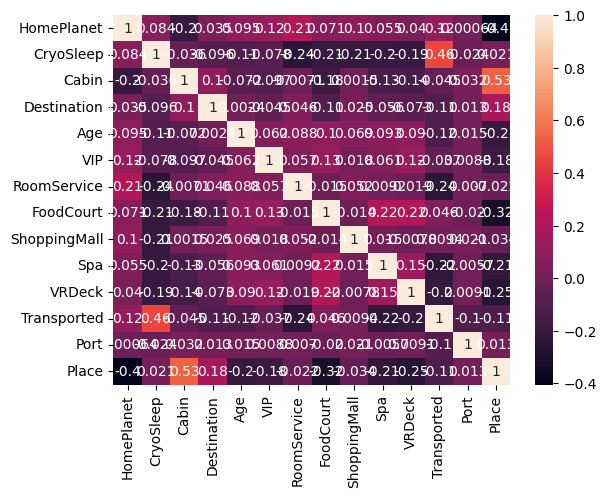

In [9]:
import seaborn as sb
df_num = df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlations of numerical columns
corr = df_num.corr()

sb.heatmap(corr, annot=True)

In [10]:
# # Apply binning
# df['RoomService'] = pd.qcut(df['RoomService'], q=4)
# df['FoodCourt'] = pd.qcut(df['FoodCourt'], q=4)
# df['ShoppingMall'] = pd.qcut(df['ShoppingMall'], q=4)
# df['Spa'] = pd.qcut(df['Spa'], q=4)
# df['VRDeck'] = pd.qcut(df['VRDeck'], q=4)

In [11]:
#print('cryo Taransported: ', sum(df[df.CryoSleep == 1].Transported), 'transported: ',sum(df.Transported))
# # Calculate mean
# df['Mean_luxury'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].mean(axis=1)

# df = df.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])

# df['BigSpender'] = np.where(df.Mean_luxury > 1000, 1,0)
# df['Mid_Spender'] = np.where(df.Mean_luxury >= 500, 1,0)
# df['Non_Spender'] = np.where(df.Mean_luxury == 0, 1,0)
# df.head(3)

{1:'55 Cancri e', 2:'PSO J318.5-22', 3:'TRAPPIST-1e'}
{1:'Earth', 2:'Europa', 3:'Mars'}
<<<<<HomePlanet to Destination>>>>
1 to 1 >>> 721
1 to 2 >>> 728
1 to 3 >>> 3354
--------------    
2 to 1 >>> 193
2 to 2 >>> 49
2 to 3 >>> 1517
-------------- 
3 to 1 >>> 886
3 to 2 >>> 19
3 to 3 >>> 1226
-------------- 

In [12]:
#print(sum(df[df.HomePlanet == 1].Transported),sum(df.HomePlanet == 1))
# sum(df[df.CryoSleep == 1].VIP)

In [13]:
# print('Slept and didnt spend: ',sum(df[df.CryoSleep == 1].Non_Spender),'All that Slept: ',sum(df.CryoSleep),'All Non-Speders: ',sum(df.Non_Spender))

In [14]:
# ids_groups = np.array([i.split("_") for i in df.PassengerId.values])
# unique_groups = np.unique(ids_groups[:,0])
# group_status = dict()
# for i in unique_groups:
#     passeng = ids_groups[ids_groups[:,0]==i]
#     for j in range(len(passeng)):
#         group_status["_".join(passeng[j])]=int(len(passeng)>1)

In [15]:
#Lastnames and groups
#lastNames = df['Name'].str.split(' ').str[-1]
ids_groups = df['PassengerId'].apply(lambda x: x.split('_')[0])

#df['FamilyId'] = pd.factorize(lastNames)[0]
df['GroupId'] = pd.factorize(ids_groups)[0]
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Port,Place,GroupId
0,0001_01,2,0,0,3,1,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,2,0
1,0002_01,1,0,0,3,1,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,0,6,1
2,0003_01,2,0,0,3,1,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,2
3,0003_02,2,0,0,3,1,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,2
4,0004_01,1,0,1,3,1,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,0,6,3


In [16]:
# mids = sum(df[df.CryoSleep == 0].Non_Spender)
# totalAwake = sum(df.CryoSleep == 0)
# awakeTransported = sum(df[df.CryoSleep == 0].Transported)
# awakeMidTransported = sum(df[(df['CryoSleep'] == 0) & (df['Age'] < 15))]['Transported'])
# print(mids/totalAwake,awakeTransported/totalAwake, awakeMidTransported / totalAwake, awakeMidTransported / mids)
# print(sum(df[df.Age < 15].CryoSleep == 0))

In [17]:
# age = 10
# print('less than:',age,'years: ', sum(df[df.Age < age].Transported),sum(df.Age < age))
# print('higher than:',age,'years: ', sum(df[df.Age > age].Transported),sum(df.Age > age))

In [18]:
newtrainDF = df
ids = newtrainDF['PassengerId'].copy()
transporteds = newtrainDF['Transported'].copy()
newtrainDF = newtrainDF.drop(columns=['PassengerId','Name','Transported'])
newtrainDF.head(3)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Port,Place,GroupId
0,2,0,0,3,1,0,0.0,0.0,0.0,0.0,0.0,1,2,0
1,1,0,0,3,1,0,109.0,9.0,25.0,549.0,44.0,0,6,1
2,2,0,0,3,1,1,43.0,3576.0,0.0,6715.0,49.0,0,1,2


In [19]:
newtrainDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   Int64  
 1   CryoSleep     8693 non-null   Int64  
 2   Cabin         8693 non-null   Int64  
 3   Destination   8693 non-null   Int64  
 4   Age           8693 non-null   Int64  
 5   VIP           8693 non-null   Int64  
 6   RoomService   8693 non-null   float64
 7   FoodCourt     8693 non-null   float64
 8   ShoppingMall  8693 non-null   float64
 9   Spa           8693 non-null   float64
 10  VRDeck        8693 non-null   float64
 11  Port          8693 non-null   Int64  
 12  Place         8693 non-null   Int64  
 13  GroupId       8693 non-null   int64  
dtypes: Int64(8), float64(5), int64(1)
memory usage: 1018.8 KB


In [20]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(newtrainDF.drop('Transported',axis=1), 
#                                                   df['Transported'], test_size=0.30, 
#                                                     random_state=101)
# newtrainDF.head(1)

In [21]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=10000)
logmodel.fit(newtrainDF, transporteds)

LogisticRegression(max_iter=10000)

In [22]:
df_test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
ids_test = df_test['PassengerId'].copy()
# # Removing NANs
# df_test["CryoSleep"].fillna(df_test["CryoSleep"].mode()[0],inplace=True)
# df_test["Age"].fillna(df_test["Age"].mean(),inplace=True)
# df_test["RoomService"].fillna(df_test["RoomService"].mean(),inplace=True)
# df_test["FoodCourt"].fillna(df_test["FoodCourt"].mean(),inplace=True)
# df_test["ShoppingMall"].fillna(df_test["ShoppingMall"].mean(),inplace=True)
# df_test["Spa"].fillna(df_test["Spa"].mean(),inplace=True)
# df_test["VRDeck"].fillna(df_test["VRDeck"].mean(),inplace=True)
# df_test.VIP = np.where(df_test.VIP,1,0)
# df_test.CryoSleep = np.where(df_test.CryoSleep,1,0)
# df_test = df_test.drop(["Name","HomePlanet","Destination","Cabin"], axis='columns')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [23]:
#CryoSleep
df_test['CryoSleep'] = df_test['CryoSleep'].replace({True: 1, False: 0})
#HomePlanet
df_test['HomePlanet'].replace('Earth', 1, inplace=True)
df_test['HomePlanet'].replace('Europa', 2, inplace=True)
df_test['HomePlanet'].replace('Mars', 3, inplace=True)
#Destination
df_test['Destination'].replace('55 Cancri e', 1, inplace=True)
df_test['Destination'].replace('PSO J318.5-22', 2, inplace=True)
df_test['Destination'].replace('TRAPPIST-1e', 3, inplace=True)
df_test['VIP'] = df['VIP'].replace({True: 1, False: 0})
df_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,1.0,1.0,G/3/S,3.0,27.0,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,1.0,0.0,F/4/S,3.0,19.0,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,2.0,1.0,C/0/S,1.0,31.0,1,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus


In [24]:
#Port or Starboard of the cabins
df_test['Port'] = df_test['Cabin'].str.split('/').str[-1]
df_test['Port'].replace('S', 0, inplace=True)
df_test['Port'].replace('P', 1, inplace=True)

#Class of the cabins
df_test['Place'] = df_test['Cabin'].str.split('/').str[0]
letter_to_int = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
df_test['Place'] = df_test['Place'].map(letter_to_int)

#Number of cabins
df_test['Cabin'] = df_test['Cabin'].str.split('/').str[1]

df_test[['HomePlanet', 'CryoSleep','Cabin', 'Destination', 'Age', 'VIP','Port','Place']] = df_test[['HomePlanet', 'CryoSleep','Cabin', 'Destination', 'Age', 'VIP','Port','Place']].astype('Int64')
df_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Port,Place
0,0013_01,1,1,3,3,27,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0,7
1,0018_01,1,0,4,3,19,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0,6
2,0019_01,2,1,0,1,31,1,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0,3


In [25]:
df_test["HomePlanet"].fillna(df_test["HomePlanet"].mode()[0],inplace=True)
df_test["CryoSleep"].fillna(df_test["CryoSleep"].mode()[0],inplace=True)
df_test["Cabin"].fillna(df_test["Cabin"].mode()[0],inplace=True)
df_test["Destination"].fillna(df_test["Destination"].mode()[0],inplace=True)
df_test["Age"].fillna(int(df_test["Age"].mean()),inplace=True)
df_test["RoomService"].fillna(df_test["RoomService"].mean(),inplace=True)
df_test["FoodCourt"].fillna(df_test["FoodCourt"].mean(),inplace=True)
df_test["ShoppingMall"].fillna(df_test["ShoppingMall"].mean(),inplace=True)
df_test["Spa"].fillna(df_test["Spa"].mean(),inplace=True)
df_test["VRDeck"].fillna(df_test["VRDeck"].mean(),inplace=True)
df_test["Port"].fillna(df_test["Port"].mode()[0],inplace=True)
df_test["Place"].fillna(df_test["Place"].mode()[0],inplace=True)
df_test.Age = np.where(df_test.Age > 15 ,1,0)
df_test.VIP = np.where(df_test.VIP,1,0)
df_test.CryoSleep = np.where(df_test.CryoSleep,1,0)

#No Nan, Null or empty cell
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4277 non-null   Int64  
 2   CryoSleep     4277 non-null   int64  
 3   Cabin         4277 non-null   Int64  
 4   Destination   4277 non-null   Int64  
 5   Age           4277 non-null   int64  
 6   VIP           4277 non-null   int64  
 7   RoomService   4277 non-null   float64
 8   FoodCourt     4277 non-null   float64
 9   ShoppingMall  4277 non-null   float64
 10  Spa           4277 non-null   float64
 11  VRDeck        4277 non-null   float64
 12  Name          4183 non-null   object 
 13  Port          4277 non-null   Int64  
 14  Place         4277 non-null   Int64  
dtypes: Int64(5), float64(5), int64(3), object(2)
memory usage: 522.2+ KB


In [26]:
# df_test['stSpenders'] = df_test[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].std(axis=1)
# df_test = df_test.drop(columns=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'])
# df_test.head()

In [27]:
# # # Apply log transformation
# df_test['RoomService'] = np.log1p(df_test['RoomService'])
# df_test['FoodCourt'] = np.log1p(df_test['FoodCourt'])
# df_test['ShoppingMall'] = np.log1p(df_test['ShoppingMall'])
# df_test['Spa'] = np.log1p(df_test['Spa'])
# df_test['VRDeck'] = np.log1p(df_test['VRDeck'])
# df_test.head(3)

In [28]:
# Apply square root transformation
# df_test['RoomService'] = df_test['RoomService']**0.5
# df_test['FoodCourt'] = df_test['FoodCourt']**0.5
# df_test['ShoppingMall'] = df['ShoppingMall']**0.5
# df_test['Spa'] = df_test['Spa']**0.5
# df_test['VRDeck'] = df_test['VRDeck']**0.5
# df_test.head(3)

In [29]:
# #Lastnames
# df['LastName'] = df['Name'].str.split(' ').str[-1]

# #Guessing Families
# df['FamilyId'] = df['PassengerId'].apply(lambda x: x.split('_')[0])
# #
# ids_groups = np.array([i.split("_") for i in df.PassengerId.values])
# # unique_groups = np.unique(ids_groups[:,0])
# df['GroupID'] = df.groupby(ids_groups[:,0]).ngroup()
# df.info()

In [30]:
#Lastnames and groups
#lastNames = df_test['Name'].str.split(' ').str[-1]
ids_groups = df_test['PassengerId'].apply(lambda x: x.split('_')[0])

#df_test['FamilyId'] = pd.factorize(lastNames)[0]
df_test['GroupId'] = pd.factorize(ids_groups)[0]
df_test.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Port,Place,GroupId
0,0013_01,1,1,3,3,1,0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0,7,0
1,0018_01,1,0,4,3,1,0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0,6,1
2,0019_01,2,1,0,1,1,1,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0,3,2


In [31]:
df_test = df_test.drop(columns=['PassengerId','Name'])
df_test.head(1)

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Port,Place,GroupId
0,1,1,3,3,1,0,0.0,0.0,0.0,0.0,0.0,0,7,0


In [32]:
# df_test['Aged'] = np.where(df_test.Age > 15, 1,0)
# df_test.head(1)

In [33]:
# columns_titles = ["HomePlanet","CryoSleep", "Destination","Age","Mean_luxury","Port","Place"]
# df_test=df_test.reindex(columns=columns_titles)
# df_test.head(3)

In [34]:
 predictions = logmodel.predict(df_test)

In [35]:
# # from sklearn.metrics import classification_report
# # print(classification_report(y_test, predictions))
# df_newTest = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
# ids_test = df_newTest['PassengerId'].copy()
ids_test.values
# predictions

array(['0013_01', '0018_01', '0019_01', ..., '9271_01', '9273_01',
       '9277_01'], dtype=object)

In [36]:
df_predictions = pd.DataFrame()
df_predictions['PassengerId'] = pd.Series(ids_test.T.values)
df_predictions['Transported'] = pd.Series(predictions)
df_predictions.Transported = np.where(df_predictions.Transported==1,True,False)
df_predictions.to_csv("14thAttempt.csv", sep=',', index=False)
df_predictions.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


In this report, the 'Precision' column tells us the proportion of positive identifications (i.e., the passenger was transported) that were actually correct. The 'Recall' column tells us the proportion of actual positives that were identified correctly. The 'F1-score' is a function of Precision and Recall and gives a balanced measure of the model's performance.

Remember, this is a basic model. Depending on the performance of the model, you might need to consider more advanced techniques such as handling class imbalance, feature engineering, or using a more complex model.